In [26]:
## Imports for Evolutionary Algorithms

import time
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [16]:
### SEEDING ###

seed = 30

In [8]:
## Defining Params for Environment
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [9]:
## Initialising Environment

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [14]:
# Instantiate the search strategies

# CMA-ES
rng = jax.random.PRNGKey(0)
cma_strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.6)
cma_params = cma_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
cma_params

EvoParams(mu_eff=Array(16.98963432, dtype=float64), c_1=Array(0.00013356, dtype=float64), c_mu=Array(0.00198713, dtype=float64), c_sigma=Array(0.13280427, dtype=float64), d_sigma=Array(1.13280427, dtype=float64), c_c=Array(0.03304903, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [15]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [13]:
## This contains all the relevant environment functionalities
# Every generation, all the actions are passed and converted to waveforms
# Then passed through to the simulation (batched_results)
# Then the results are passed to the reward function
# And the fitness = -reward is returned!

def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)
    # res_drive are the final resonator waveforms

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward 
    # Since the evo algo default implementations deal with minimisation

    return fitness.astype(jnp.float32)

# CMA-ES for 20k Generations

# 

In [50]:
strat = cma_strategy
params = cma_params
strat_name = 'CMA_ES'

# Make the Jax Random Seed in the Training Cell
# To ensure same seed is used for all runs
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

state = strat.initialize(_rng, params)

start = time.time()

# For Logging
print_rate = 100 # For monitoring the learning
total_train_gens = 20_000

def_reward = 100.
fitness_arr = np.zeros(total_train_gens) - def_reward
actions_arr = np.zeros((total_train_gens, env.num_actions))

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(total_train_gens):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = strat.ask(rng_gen, state, params) # Sampling actions from strategy
    fitness = custom_rollout(x) # Function we defined
    state = strat.tell(x, fitness, state, params) # Updating strategy with fitnesses

    # Logging
    fitness_arr[t] = state.best_fitness
    actions_arr[t] = state.best_member

    if (t + 1) % print_rate == 0:
        print(f"{strat_name} - # Gen: {t + 1}|Fitness: {state.best_fitness}")
        print(f"Time: {time.time() - start}")

CMA_ES - # Gen: 100|Fitness: 25.984163284301758
Time: 2.340299129486084
CMA_ES - # Gen: 200|Fitness: 1.0778732299804688
Time: 4.5718231201171875
CMA_ES - # Gen: 300|Fitness: -6.522844314575195
Time: 6.436236143112183
CMA_ES - # Gen: 400|Fitness: -7.880298137664795
Time: 8.40494418144226
CMA_ES - # Gen: 500|Fitness: -8.370514869689941
Time: 10.326982259750366


KeyboardInterrupt: 

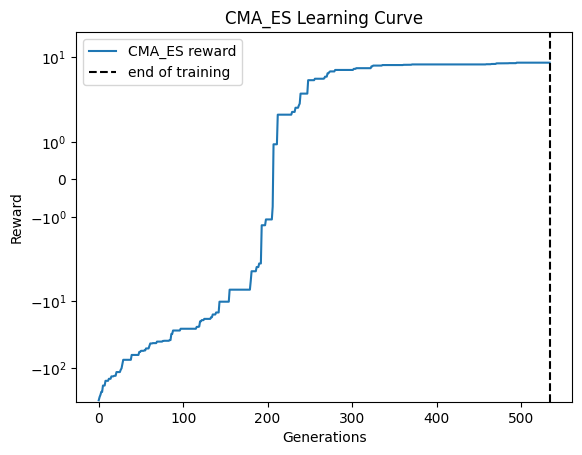

In [51]:
## Plot Learning

cma_reward_arr = -fitness_arr
cma_action_arr = actions_arr

cma_end_ind = jnp.where(cma_reward_arr == def_reward, size=1)[0][0]

plt.plot(cma_reward_arr[:cma_end_ind], label=f'{strat_name} reward')
plt.axvline(x=cma_end_ind, label='end of training', color='black', linestyle='dashed')
plt.yscale('symlog')
plt.legend()
plt.xlabel('Generations')
plt.ylabel('Reward')
plt.title(f'{strat_name} Learning Curve')
plt.show()

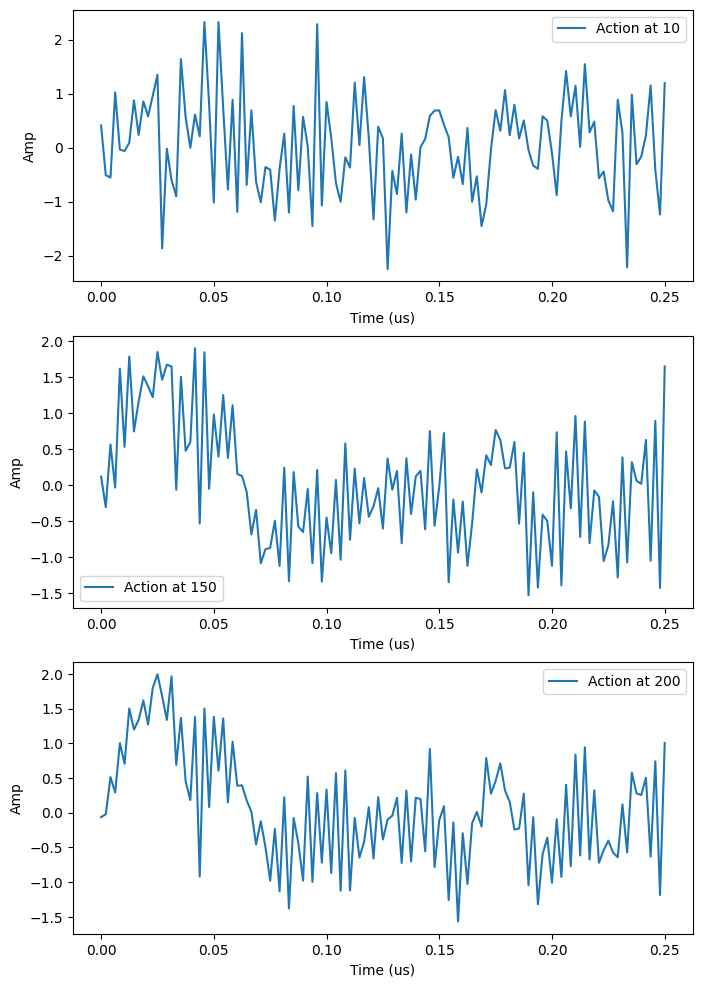

In [52]:
## Plotting Actions at different points

fig, ax = plt.subplots(3, figsize=(8.0, 12.0))

# Set the below indices to plot actions at different points in the learning
ind_1 = 10
ind_2 = 150
ind_3 = 200

ax[0].plot(env.ts_action, cma_action_arr[ind_1], label=f'Action at {ind_1}')
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Amp')
ax[0].legend()

ax[1].plot(env.ts_action, cma_action_arr[ind_2], label=f'Action at {ind_2}')
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Amp')
ax[1].legend()

ax[2].plot(env.ts_action, cma_action_arr[ind_3], label=f'Action at {ind_3}')
ax[2].set_xlabel('Time (us)')
ax[2].set_ylabel('Amp')
ax[2].legend()

plt.show()

# Simulated Annealing for 20k Generations

In [53]:
strat = sim_anneal
params = sim_params
strat_name = 'SimAnneal'

# Make the Jax Random Seed in the Training Cell
# To ensure same seed is used for all runs
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

state = strat.initialize(_rng, params)

start = time.time()

# For Logging
print_rate = 100 # For monitoring the learning
total_train_gens = 20_000

def_reward = 100.
fitness_arr = np.zeros(total_train_gens) - def_reward
actions_arr = np.zeros((total_train_gens, env.num_actions))

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(total_train_gens):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = strat.ask(rng_gen, state, params) # Sampling actions from strategy
    fitness = custom_rollout(x) # Function we defined
    state = strat.tell(x, fitness, state, params) # Updating strategy with fitnesses

    # Logging
    fitness_arr[t] = state.best_fitness
    actions_arr[t] = state.best_member

    if (t + 1) % print_rate == 0:
        print(f"{strat_name} - # Gen: {t + 1}|Fitness: {state.best_fitness}")
        print(f"Time: {time.time() - start}")

SimAnneal - # Gen: 100|Fitness: 12.459181785583496
Time: 1.8705790042877197
SimAnneal - # Gen: 200|Fitness: -2.231156349182129
Time: 3.4029459953308105
SimAnneal - # Gen: 300|Fitness: -2.5811104774475098
Time: 5.032172203063965
SimAnneal - # Gen: 400|Fitness: -2.5811104774475098
Time: 6.45527720451355
SimAnneal - # Gen: 500|Fitness: -2.5811104774475098
Time: 7.960314989089966


KeyboardInterrupt: 

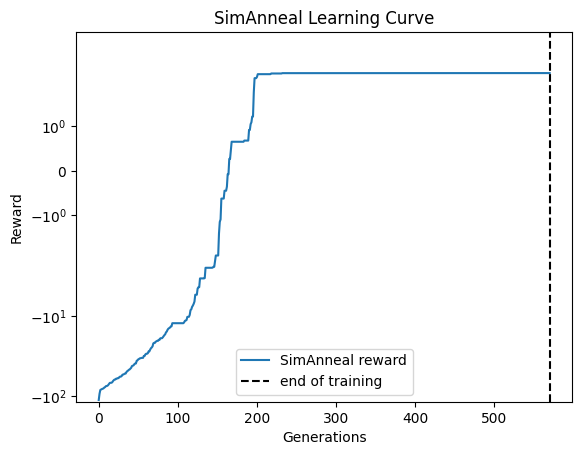

In [54]:
## Plot Learning

sim_reward_arr = -fitness_arr
sim_action_arr = actions_arr

sim_end_ind = jnp.where(sim_reward_arr == def_reward, size=1)[0][0]

plt.plot(sim_reward_arr[:sim_end_ind], label=f'{strat_name} reward')
plt.axvline(x=sim_end_ind, label='end of training', color='black', linestyle='dashed')
plt.yscale('symlog')
plt.legend()
plt.xlabel('Generations')
plt.ylabel('Reward')
plt.title(f'{strat_name} Learning Curve')
plt.show()

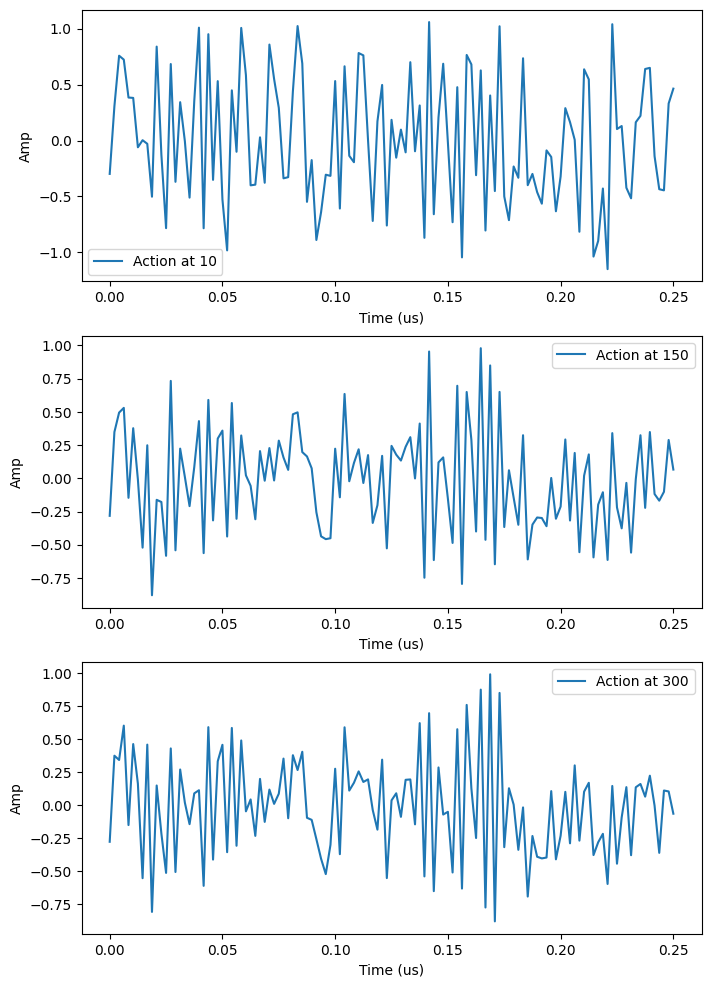

In [55]:
## Plotting Actions at different points

fig, ax = plt.subplots(3, figsize=(8.0, 12.0))

# Set the below indices to plot actions at different points in the learning
ind_1 = 10
ind_2 = 150
ind_3 = 300

ax[0].plot(env.ts_action, sim_action_arr[ind_1], label=f'Action at {ind_1}')
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Amp')
ax[0].legend()

ax[1].plot(env.ts_action, sim_action_arr[ind_2], label=f'Action at {ind_2}')
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Amp')
ax[1].legend()

ax[2].plot(env.ts_action, sim_action_arr[ind_3], label=f'Action at {ind_3}')
ax[2].set_xlabel('Time (us)')
ax[2].set_ylabel('Amp')
ax[2].legend()

plt.show()

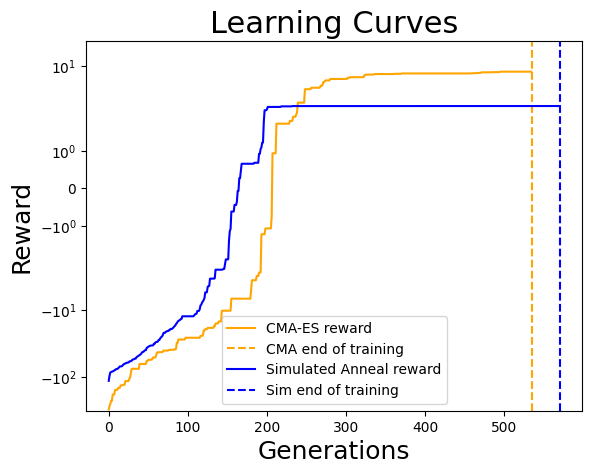

In [58]:
plt.plot(cma_reward_arr[:cma_end_ind], label='CMA-ES reward', color='orange')
plt.axvline(x=cma_end_ind, label='CMA end of training', color='orange', linestyle='dashed')
plt.plot(sim_reward_arr[:sim_end_ind], label='Simulated Anneal reward', color='blue')
plt.axvline(x=sim_end_ind, label='Sim end of training', color='blue', linestyle='dashed')
plt.yscale('symlog')
plt.legend()
plt.xlabel('Generations', fontsize=18)
plt.ylabel('Reward', fontsize=18)
plt.title('Learning Curves', fontsize=22)
plt.show()